In [1]:
!pip install tensorflow-addons

import numpy as np
import tensorflow as tf
import scipy as scp
import sklearn as skl
from tqdm import tqdm
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import tensorflow_addons as tfa
import sklearn.metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
# (X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_train = np.concatenate([X_train,X_train,X_train],axis = 3)
X_test = X_test.reshape(-1, 28, 28, 1)
X_test = np.concatenate([X_test,X_test,X_test],axis = 3)


In [4]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 3)
(10000, 28, 28, 3)


In [5]:
aug = iaa.Grayscale(alpha=(0.0, 1.0))
def def_augment(images, n=2, m=3):
    #
    rand_aug = iaa.RandAugment(n=n, m=m)
    
    #     @tf.numpy_function
    # def augment(images):
    #     # Input to `augment()` is a TensorFlow tensor which
    #     # is not supported by `imgaug`. This is why we first
    #     # convert it to its `numpy` variant.
    #     print(images.shape)
    #     images = aug(images=images)
    #     return rand_aug(images=images).reshape(-1,784)

    images = aug(images=images)
    return rand_aug(images=images)


In [6]:
X1_test = def_augment(X_test)
X1_train = def_augment(X_train)

In [7]:
# X1_train = tf.keras.preprocessing.image.random_rotation(
#     X_train,
#     30,
#     row_axis=1,
#     col_axis=2,
#     channel_axis=0,
#     fill_mode='nearest',
#     cval=0.0,
#     interpolation_order=1
# )

# X1_train = tf.keras.preprocessing.image.random_shift(
#     X1_train,
#     0.1,
#     0.1,
#     row_axis=1,
#     col_axis=2,
#     channel_axis=0,
#     fill_mode='nearest',
#     cval=0.0,
#     interpolation_order=1
# )

# X1_test = tf.keras.preprocessing.image.random_rotation(
#     X_test,
#     30,
#     row_axis=1,
#     col_axis=2,
#     channel_axis=0,
#     fill_mode='nearest',
#     cval=0.0,
#     interpolation_order=1
# )

# X1_test = tf.keras.preprocessing.image.random_shift(
#     X1_test,
#     0.1,
#     0.1,
#     row_axis=1,
#     col_axis=2,
#     channel_axis=0,
#     fill_mode='nearest',
#     cval=0.0,
#     interpolation_order=1
# )

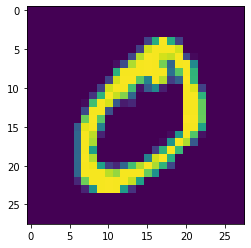

In [8]:
plt.imshow(X_train[1][:, :, 1])

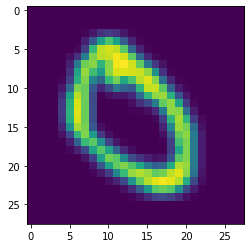

In [9]:
plt.imshow(X1_train[1][:, :, 1])

In [10]:
X_train = X_train[:, :, :, 1].reshape(-1, 784).astype("float32") / 255.0
X1_train = X1_train[:, :, :, 1].reshape(-1, 784).astype("float32") / 255.0
X_test = X_test[:, :, :, 1].reshape(-1, 784).astype("float32") / 255.0
X1_test = X1_test[:, :, :, 1].reshape(-1, 784).astype("float32") / 255.0

# X_train = X_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
# X1_train = X1_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
# X_test = X_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0
# X1_test = X1_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0


In [11]:
def tf_unif_prior_crossentropy(pred1,pred2):
    N, C = pred1.shape 
    t_c = 0.1
    t_r = 0.1
    a = tf.nn.softmax(pred2/t_c, axis=0)
    b = tf.linalg.norm(a, ord=1,axis=1)
    # try :
    c = a/tf.reshape(b,(N,-1))
    # except :
    #     try :
    #         c = a/tf.reshape(b,(X_train.shape[0]%batch_size,-1))
    #     except :
    #         c = a/tf.reshape(b,(X_test.shape[0]%batch_size,-1))
            

    part11 = c
    d = tf.nn.softmax(pred1/t_r, axis=1)
    part21 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)), (-1,C))
    loss_1 = -tf.math.reduce_sum( part11 * part21 , axis=-1)


    a = tf.nn.softmax(pred1/t_c)
    b = tf.linalg.norm(a, ord=1,axis=1)
    c = a/tf.reshape(b,(N,-1))
    part12 = c
    d = tf.nn.softmax(pred2/t_r, axis=1)
    part22 = tf.reshape(tf.math.log(N/C *d/tf.linalg.norm(d, ord=1, axis=0)),(-1,C))
    loss_2 = -tf.math.reduce_sum( part12*part22 , axis=-1)

    return tf.math.reduce_mean(1/2*(loss_1+loss_2))

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28 * 28), dtype=tf.float32),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10,activation = None, dtype='float32'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("softmax")
    ])

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(28, 28, 1), dtype=tf.float32),
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(10,activation = None, dtype='float32'),
#     # tf.keras.layers.Activation("softmax")
#     ])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

NUM_EPOCHS = 100
EPOCH_PER_DISPLAY = 1
total_loss = []
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X1_train))
train_dataset = train_dataset.shuffle(X_train.shape[0]).batch(500)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, X1_test, Y_test))
test_dataset = test_dataset.shuffle(X_test.shape[0]).batch(100)

for epoch in range(NUM_EPOCHS):

  running_loss = []

  for input1, input2 in tqdm(train_dataset):
    with tf.GradientTape() as tape:

      pred1 = model(input1, training=True)
      pred2 = model(input2, training=True)

      loss_ = tf_unif_prior_crossentropy(pred1, pred2)

      grads = tape.gradient(loss_, model.trainable_variables)
      
    running_loss.append(loss_)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
  epoch_loss = np.mean(running_loss)
  if (epoch + 1) % EPOCH_PER_DISPLAY == 0:
    print("Epoch {}: Train Loss: {:.4f}".format(epoch+1, epoch_loss), end="")


  valid_loss = []
  valid_nmi = []
  valid_ami = []
  valid_ari = []
  valid_acc = []

  for input1, input2, true_label in test_dataset:
    pred1 = model(input1, training=False)
    pred2 = model(input2, training=False)
    loss_ = tf_unif_prior_crossentropy(pred1, pred2)
    valid_loss.append(loss_)
    pred1 = pred1.numpy().argmax(axis=1)
    pred2 = pred2.numpy().argmax(axis=1)
    valid_nmi.append(skl.metrics.normalized_mutual_info_score(true_label, pred1))
    valid_ami.append(skl.metrics.adjusted_mutual_info_score(pred1, pred2))
    valid_ari.append(skl.metrics.adjusted_rand_score(pred1, pred2))
    valid_acc.append(skl.metrics.accuracy_score(pred1, pred2))
    cor_cnt = 0
    for tmp1, tmp2 in zip(pred1, pred2):
      if (tmp1 == tmp2):
        cor_cnt += 1
  print("   Valid Loss: {:.4f}    NMI: {:.4f}   AMI: {:.4f}   ARI: {:.4f}   ACC: {:.4f}".format(np.mean(valid_loss), 
                                                                                np.mean(valid_nmi), np.mean(valid_ami), 
                                                                                np.mean(valid_ari), np.mean(valid_acc), cor_cnt))

100%|██████████| 120/120 [00:21<00:00,  5.59it/s]


Epoch 1: Train Loss: 2.3459   Valid Loss: 1.8821    NMI: 0.5198   AMI: 0.5947   ARI: 0.5617   ACC: 0.7459


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 2: Train Loss: 1.7619   Valid Loss: 1.3424    NMI: 0.6253   AMI: 0.7151   ARI: 0.6897   ACC: 0.8218


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 3: Train Loss: 1.3978   Valid Loss: 1.1755    NMI: 0.6676   AMI: 0.7466   ARI: 0.7200   ACC: 0.8413


100%|██████████| 120/120 [00:13<00:00,  9.19it/s]


Epoch 4: Train Loss: 1.1929   Valid Loss: 1.0868    NMI: 0.6795   AMI: 0.7855   ARI: 0.7623   ACC: 0.8601


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 5: Train Loss: 1.0849   Valid Loss: 1.0393    NMI: 0.6945   AMI: 0.7751   ARI: 0.7480   ACC: 0.8513


100%|██████████| 120/120 [00:13<00:00,  8.60it/s]


Epoch 6: Train Loss: 1.0201   Valid Loss: 0.9431    NMI: 0.6998   AMI: 0.8069   ARI: 0.7813   ACC: 0.8716


100%|██████████| 120/120 [00:12<00:00,  9.25it/s]


Epoch 7: Train Loss: 0.9604   Valid Loss: 0.9006    NMI: 0.7108   AMI: 0.8035   ARI: 0.7798   ACC: 0.8696


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 8: Train Loss: 0.9167   Valid Loss: 0.8782    NMI: 0.7146   AMI: 0.8127   ARI: 0.7863   ACC: 0.8776


100%|██████████| 120/120 [00:13<00:00,  8.69it/s]


Epoch 9: Train Loss: 0.8814   Valid Loss: 0.9144    NMI: 0.7136   AMI: 0.8073   ARI: 0.7816   ACC: 0.8679


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 10: Train Loss: 0.8594   Valid Loss: 0.8137    NMI: 0.7189   AMI: 0.8481   ARI: 0.8303   ACC: 0.9051


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 11: Train Loss: 0.8401   Valid Loss: 0.8248    NMI: 0.7217   AMI: 0.8414   ARI: 0.8231   ACC: 0.9042


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 12: Train Loss: 0.8332   Valid Loss: 0.7970    NMI: 0.7229   AMI: 0.8391   ARI: 0.8192   ACC: 0.8987


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 13: Train Loss: 0.7979   Valid Loss: 0.7880    NMI: 0.7283   AMI: 0.8651   ARI: 0.8480   ACC: 0.9233


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 14: Train Loss: 0.7892   Valid Loss: 0.7739    NMI: 0.7218   AMI: 0.8530   ARI: 0.8380   ACC: 0.9108


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 15: Train Loss: 0.7758   Valid Loss: 0.7610    NMI: 0.7225   AMI: 0.8555   ARI: 0.8376   ACC: 0.9108


100%|██████████| 120/120 [00:13<00:00,  8.79it/s]


Epoch 16: Train Loss: 0.7711   Valid Loss: 0.7795    NMI: 0.7265   AMI: 0.8617   ARI: 0.8419   ACC: 0.9209


100%|██████████| 120/120 [00:15<00:00,  7.93it/s]


Epoch 17: Train Loss: 0.7568   Valid Loss: 0.7465    NMI: 0.7225   AMI: 0.8613   ARI: 0.8427   ACC: 0.9170


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 18: Train Loss: 0.7479   Valid Loss: 0.7662    NMI: 0.7237   AMI: 0.8530   ARI: 0.8364   ACC: 0.9107


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 19: Train Loss: 0.7363   Valid Loss: 0.7752    NMI: 0.7285   AMI: 0.8688   ARI: 0.8523   ACC: 0.9248


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 20: Train Loss: 0.7300   Valid Loss: 0.7811    NMI: 0.7259   AMI: 0.8628   ARI: 0.8448   ACC: 0.9196


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 21: Train Loss: 0.7215   Valid Loss: 0.7622    NMI: 0.7234   AMI: 0.8613   ARI: 0.8446   ACC: 0.9174


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 22: Train Loss: 0.7273   Valid Loss: 0.7853    NMI: 0.7281   AMI: 0.8752   ARI: 0.8588   ACC: 0.9286


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 23: Train Loss: 0.7166   Valid Loss: 0.7796    NMI: 0.7280   AMI: 0.8704   ARI: 0.8521   ACC: 0.9249


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 24: Train Loss: 0.7232   Valid Loss: 0.7595    NMI: 0.7244   AMI: 0.8737   ARI: 0.8578   ACC: 0.9276


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 25: Train Loss: 0.7167   Valid Loss: 0.7730    NMI: 0.7290   AMI: 0.8565   ARI: 0.8393   ACC: 0.9105


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 26: Train Loss: 0.7114   Valid Loss: 0.7836    NMI: 0.7265   AMI: 0.8707   ARI: 0.8541   ACC: 0.9268


100%|██████████| 120/120 [00:13<00:00,  9.18it/s]


Epoch 27: Train Loss: 0.7246   Valid Loss: 0.7508    NMI: 0.7254   AMI: 0.8598   ARI: 0.8452   ACC: 0.9151


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 28: Train Loss: 0.7287   Valid Loss: 0.7877    NMI: 0.7309   AMI: 0.8631   ARI: 0.8460   ACC: 0.9155


100%|██████████| 120/120 [00:13<00:00,  9.12it/s]


Epoch 29: Train Loss: 0.7247   Valid Loss: 0.8154    NMI: 0.7244   AMI: 0.8856   ARI: 0.8713   ACC: 0.9386


100%|██████████| 120/120 [00:13<00:00,  9.10it/s]


Epoch 30: Train Loss: 0.7427   Valid Loss: 0.9706    NMI: 0.7309   AMI: 0.8188   ARI: 0.7805   ACC: 0.8981


100%|██████████| 120/120 [00:13<00:00,  9.04it/s]


Epoch 31: Train Loss: 0.7348   Valid Loss: 0.7613    NMI: 0.7254   AMI: 0.8712   ARI: 0.8567   ACC: 0.9248


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 32: Train Loss: 0.7146   Valid Loss: 0.7774    NMI: 0.7274   AMI: 0.8734   ARI: 0.8551   ACC: 0.9268


100%|██████████| 120/120 [00:12<00:00,  9.25it/s]


Epoch 33: Train Loss: 0.7023   Valid Loss: 0.7766    NMI: 0.7279   AMI: 0.8701   ARI: 0.8556   ACC: 0.9230


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 34: Train Loss: 0.7125   Valid Loss: 0.7778    NMI: 0.7288   AMI: 0.8571   ARI: 0.8415   ACC: 0.9102


100%|██████████| 120/120 [00:12<00:00,  9.24it/s]


Epoch 35: Train Loss: 0.6951   Valid Loss: 0.7710    NMI: 0.7275   AMI: 0.8756   ARI: 0.8575   ACC: 0.9292


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 36: Train Loss: 0.7046   Valid Loss: 0.7508    NMI: 0.7325   AMI: 0.8647   ARI: 0.8478   ACC: 0.9152


100%|██████████| 120/120 [00:13<00:00,  8.97it/s]


Epoch 37: Train Loss: 0.6984   Valid Loss: 0.7596    NMI: 0.7304   AMI: 0.8748   ARI: 0.8607   ACC: 0.9261


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 38: Train Loss: 0.6901   Valid Loss: 0.7785    NMI: 0.7291   AMI: 0.8616   ARI: 0.8475   ACC: 0.9135


100%|██████████| 120/120 [00:12<00:00,  9.26it/s]


Epoch 39: Train Loss: 0.6994   Valid Loss: 0.7992    NMI: 0.7274   AMI: 0.8629   ARI: 0.8437   ACC: 0.9232


100%|██████████| 120/120 [00:13<00:00,  9.11it/s]


Epoch 40: Train Loss: 0.6833   Valid Loss: 0.7999    NMI: 0.7305   AMI: 0.8639   ARI: 0.8450   ACC: 0.9228


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 41: Train Loss: 0.6732   Valid Loss: 0.8408    NMI: 0.7261   AMI: 0.8420   ARI: 0.8237   ACC: 0.8985


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 42: Train Loss: 0.6708   Valid Loss: 0.7719    NMI: 0.7280   AMI: 0.8673   ARI: 0.8531   ACC: 0.9218


100%|██████████| 120/120 [00:12<00:00,  9.39it/s]


Epoch 43: Train Loss: 0.6665   Valid Loss: 0.7933    NMI: 0.7272   AMI: 0.8700   ARI: 0.8529   ACC: 0.9247


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 44: Train Loss: 0.6663   Valid Loss: 0.7671    NMI: 0.7324   AMI: 0.8570   ARI: 0.8424   ACC: 0.9111


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 45: Train Loss: 0.6676   Valid Loss: 0.7671    NMI: 0.7367   AMI: 0.8682   ARI: 0.8515   ACC: 0.9229


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 46: Train Loss: 0.6586   Valid Loss: 0.7734    NMI: 0.7333   AMI: 0.8617   ARI: 0.8453   ACC: 0.9146


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 47: Train Loss: 0.6557   Valid Loss: 0.7719    NMI: 0.7265   AMI: 0.8729   ARI: 0.8567   ACC: 0.9261


100%|██████████| 120/120 [00:12<00:00,  9.37it/s]


Epoch 48: Train Loss: 0.6666   Valid Loss: 0.7642    NMI: 0.7306   AMI: 0.8787   ARI: 0.8635   ACC: 0.9309


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 49: Train Loss: 0.6741   Valid Loss: 0.7946    NMI: 0.7308   AMI: 0.8641   ARI: 0.8517   ACC: 0.9179


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 50: Train Loss: 0.6641   Valid Loss: 0.7680    NMI: 0.7287   AMI: 0.8627   ARI: 0.8435   ACC: 0.9143


100%|██████████| 120/120 [00:12<00:00,  9.26it/s]


Epoch 51: Train Loss: 0.6627   Valid Loss: 0.7963    NMI: 0.7304   AMI: 0.8647   ARI: 0.8433   ACC: 0.9233


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 52: Train Loss: 0.6580   Valid Loss: 0.7931    NMI: 0.7306   AMI: 0.8726   ARI: 0.8572   ACC: 0.9302


100%|██████████| 120/120 [00:13<00:00,  8.98it/s]


Epoch 53: Train Loss: 0.6626   Valid Loss: 0.8332    NMI: 0.7331   AMI: 0.8290   ARI: 0.8048   ACC: 0.8833


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 54: Train Loss: 0.6625   Valid Loss: 0.7645    NMI: 0.7344   AMI: 0.8737   ARI: 0.8591   ACC: 0.9277


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 55: Train Loss: 0.6649   Valid Loss: 0.7868    NMI: 0.7305   AMI: 0.8617   ARI: 0.8442   ACC: 0.9197


100%|██████████| 120/120 [00:20<00:00,  5.86it/s]


Epoch 56: Train Loss: 0.6598   Valid Loss: 0.7863    NMI: 0.7305   AMI: 0.8585   ARI: 0.8411   ACC: 0.9178


 18%|█▊        | 21/120 [00:02<00:11,  8.61it/s]


KeyboardInterrupt: ignored

(100, 10)
(100,)
(10000,)
[9 0 0 6 3 0 4 8 9 3 0 9 0 8 9 6 9 1 9 3 7 9 4 4 4 0 8 9 9 8]
---
[9 0 3 6 3 0 4 8 9 3 0 5 0 8 9 2 9 1 9 3 7 9 4 4 4 0 8 9 9 8]
---
tf.Tensor([7 5 5 0 5 3 6 4 7 8 8 7 3 9 7 0 9 1 7 8 2 7 6 6 6 5 9 7 7 9], shape=(30,), dtype=uint8)
0.915916091164418
0.8996810325727336
0.8843540567310978
0.15
0.13


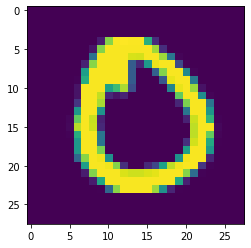

In [15]:
for input1, input2, true_label in test_dataset:
    plt.imshow(input1[3].numpy().reshape(28, 28))
    pred1 = model(input1, training=False)
    pred2 = model(input2, training=False)
    print(pred1.shape)
    # loss_ = tf_unif_prior_crossentropy(pred1, pred2)
    # valid_loss.append(loss_)
    pred1 = pred1.numpy().argmax(axis=1)
    pred2 = pred2.numpy().argmax(axis=1)
    print(pred1.shape)
    print(Y_test.shape)
    print(pred1[:30])
    print("---")
    print(pred2[:30])
    print("---")
    print(str(true_label[:30]))
    # print(skl.metrics.normalized_mutual_info_score(true_label, pred1))
    # print(skl.metrics.normalized_mutual_info_score(true_label, pred2))
    print(skl.metrics.normalized_mutual_info_score(pred1, pred2))
    print(skl.metrics.adjusted_mutual_info_score(pred1, pred2))
    print(skl.metrics.adjusted_rand_score(pred1, pred2))
    print(skl.metrics.accuracy_score(true_label, pred1))
    print(skl.metrics.accuracy_score(true_label, pred2))
    cor_cnt = 0
    for tmp1, tmp2 in zip(pred1, pred2):
      if (tmp1 == tmp2):
        cor_cnt += 1
    break